## Import necessary libraries

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis, boxcox
from sklearn.preprocessing import PowerTransformer, RobustScaler, QuantileTransformer, MinMaxScaler, StandardScaler

### Load data

In [83]:
data_filepath = './../data/price_elasticity_data.csv'
df = pd.read_csv(data_filepath)

### Basic data checks

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Product            156 non-null    object 
 1   Menu_Price         156 non-null    float64
 2   Pizza_Count        156 non-null    float64
 3   Profit_Percentage  156 non-null    float64
dtypes: float64(3), object(1)
memory usage: 5.0+ KB


In [85]:
df.isnull().sum()

Product              0
Menu_Price           0
Pizza_Count          0
Profit_Percentage    0
dtype: int64

### Calculate summary statistics

In [86]:
def calculate_statistics(product_data, column='Menu_Price'):
    """
    Calculate summary statistics for a given column in the dataset
    :param product_data: 
    :param column: 
    :return: 
    """
    stats = product_data[column].agg(['min', 'mean', 'max', 'std'])
    stats['skewness'] = skew(product_data[column])
    stats['kurtosis'] = kurtosis(product_data[column])
    return stats

### Calculate statistics for Individuale

In [87]:
individuale_stats = calculate_statistics(df[df['Product'] == 'Individuale'])
print(f"Individuale Price Statistics:\n{individuale_stats}")

Individuale Price Statistics:
min          4.820000
mean         9.162289
max         18.610000
std          1.947488
skewness     1.358867
kurtosis     6.460622
Name: Menu_Price, dtype: float64


### Analysis
Here's the analysis of the Individuale price statistics:

1. **Minimum Price (min):** The lowest menu price for Individuale is 4.82.
2. **Mean Price (mean):** The average menu price for Individuale is approximately 9.16.
3. **Maximum Price (max):** The highest menu price for Individuale is 18.61.
4. **Standard Deviation (std):** The standard deviation of the menu prices is approximately 1.95, indicating the spread or variability of the prices around the mean.
5. **Skewness (skewness):** The skewness is 1.36, which indicates that the distribution of menu prices is positively skewed (right-skewed). This means there are a few menu prices that are significantly higher than the mean, pulling the tail of the distribution to the right.
6. **Kurtosis (kurtosis):** The kurtosis is 6.46, which indicates a leptokurtic distribution. This means that the distribution has heavier tails and a sharper peak than a normal distribution. There are more extreme values (outliers) than in a normal distribution.

### Implications:
- **Pricing Strategy:** The positive skewness suggests that while most menu prices are clustered around the lower end, there are a few high-priced items. This could be indicative of premium offerings or special items on the menu.
- **Variability:** The standard deviation indicates a moderate variability in the menu prices. Given the range from 4.82 to 18.61, there is a diverse set of prices within the Individuale category.
- **Outliers:** The high kurtosis suggests that there are outliers in the data. These outliers could be special items or incorrectly priced items and might need further investigation.

### Recommendations:
- **Further Investigation:** It might be useful to look at the specific items contributing to the high skewness and kurtosis to understand if they are special offerings, mistakes, or items that could be optimized in terms of pricing.
- **Box-Cox Transformation:** To address the skewness and kurtosis, consider applying transformations like Box-Cox, which can make the data more normally distributed and potentially improve any subsequent analyses or models.

Overall, this analysis suggests that there is significant diversity in the pricing of Individuale items, with a tendency towards lower prices but a notable presence of higher-priced items.

### Calculate statistics for Communita

In [88]:
communita_stats = calculate_statistics(df[df['Product'] == 'Communita'])
print(f"\nCommunita Price Statistics:\n{communita_stats}")


Communita Price Statistics:
min          7.250000
mean        12.886706
max         25.640000
std          2.436303
skewness     1.497773
kurtosis     7.400252
Name: Menu_Price, dtype: float64


### Analysis
Here's the analysis of the Communita price statistics:

1. **Minimum Price (min):** The lowest menu price for Communita is 7.25.
2. **Mean Price (mean):** The average menu price for Communita is approximately 12.89.
3. **Maximum Price (max):** The highest menu price for Communita is 25.64.
4. **Standard Deviation (std):** The standard deviation of the menu prices is approximately 2.44, indicating the spread or variability of the prices around the mean.
5. **Skewness (skewness):** The skewness is 1.50, which indicates that the distribution of menu prices is positively skewed (right-skewed). This means there are a few menu prices that are significantly higher than the mean, pulling the tail of the distribution to the right.
6. **Kurtosis (kurtosis):** The kurtosis is 7.40, which indicates a leptokurtic distribution. This means that the distribution has heavier tails and a sharper peak than a normal distribution. There are more extreme values (outliers) than in a normal distribution.

### Implications:
- **Pricing Strategy:** The positive skewness suggests that while most menu prices are clustered around the lower end, there are a few high-priced items. This could be indicative of premium offerings or special items on the menu.
- **Variability:** The standard deviation indicates a moderate variability in the menu prices. Given the range from 7.25 to 25.64, there is a diverse set of prices within the Communita category.
- **Outliers:** The high kurtosis suggests that there are outliers in the data. These outliers could be special items or incorrectly priced items and might need further investigation.

### Recommendations:
- **Further Investigation:** It might be useful to look at the specific items contributing to the high skewness and kurtosis to understand if they are special offerings, mistakes, or items that could be optimized in terms of pricing.
- **Box-Cox Transformation:** To address the skewness and kurtosis, consider applying transformations like Box-Cox, which can make the data more normally distributed and potentially improve any subsequent analyses or models.

Overall, this analysis suggests that there is significant diversity in the pricing of Communita items, with a tendency towards lower prices but a notable presence of higher-priced items. The high variability and presence of outliers indicate the need for careful consideration of pricing strategies and potential adjustments.

# Feature Engineering
There are necessary features that need to be engineered:
- Gross Profit is crucial since our task is to maximise profit in dollars. 
- Gross Profit needs to be calculated as we only have Gross Margin in percentage terms.
- Cost per unit is also important to understand the cost structure of the products, and therefore the gross profit

I have questions that require engineering additional features:
- The cost per unit of the product is not constant. This inconsistency raises the question of why this variability exists, and is unanswered at this time.
- The `Pizza_Count` feature seems unusual. The number of pizzas sold should be an integer because the franchise sells only whole pizzas. The supplied numbers are floats, which needs further investigation.

## Key Points

### Cost Price Consistency:
- **Variable Costs**: If the cost per unit varies significantly, it might indicate variable costs due to factors like supplier pricing, bulk discounts, or different production processes.
- **Constant Costs**: If the cost per unit is relatively constant, it simplifies the profit maximisation model, allowing a primary focus on price elasticity and demand.

### Gross Profit:
- **Relevance**: Gross Profit directly ties to the business objective of maximising total profit. Focusing on profit percentages alone doesn't provide a complete picture of financial health.
- **Decision-Making**: By concentrating on Gross Profit, we can better assess which products and pricing strategies contribute more to overall profitability.

### Analysis Approach:
- **Examine Cost Per Unit**: Calculate and plot the cost per unit for each product to determine if it’s constant or variable.
- **Maximize Profit in Dollars**: Focus on total profit in dollars when optimising pricing strategies, aligning with the business goal of maximising overall profit.

### Calculate the Cost Price per unit

In [89]:
df['cost_per_unit'] = df['Menu_Price'] * (1 - df['Profit_Percentage'] / 100)
df['gross_profit'] = (df['Menu_Price'] - df['cost_per_unit']) * df['Pizza_Count']
df['sales_value'] = df['Menu_Price'] * df['Pizza_Count']
df.head()

,Product,Menu_Price,Pizza_Count,Profit_Percentage,cost_per_unit,gross_profit,sales_value
0,Individuale,4.8200,6.583538,25.263382,3.602305,8.016741,31.732653
1,Individuale,5.2500,6.763684,26.845586,3.840607,9.532690,35.509341
2,Individuale,5.7500,6.690481,30.214454,4.012669,11.623581,38.470267
3,Individuale,6.2275,6.138780,33.417930,4.146398,12.775426,38.229255
4,Individuale,6.5500,5.977077,35.425975,4.229599,13.869217,39.149852


### Calculate total profit and COGS for each product

In [90]:
gross_profit = df.groupby('Product').agg({
    'gross_profit': 'sum',
}).reset_index()
gross_profit

,Product,gross_profit
0,Communita,1581.318418
1,Individuale,1518.688013


In [91]:
total_gp = 1581.318418 + 1518.688013
total_gp

3100.006431

In [92]:
total_sales = df['sales_value'].sum()
total_sales

np.float64(6915.514540393933)

## Conclusions from Summary Statistics

| Product     | Minimum Price | Mean Price | Maximum Price | Standard Deviation | Skewness | Kurtosis |
|-------------|---------------|------------|---------------|--------------------|----------|----------|
| Individuale | 4.82          | 9.16       | 18.61         | 1.95               | 1.36     | 6.46     |
| Communita   | 7.25          | 12.89      | 25.64         | 2.44               | 1.50     | 7.40     |

**Individuale**:
- Skewness: positively skewed
- Kurtosis: leptokurtic, indicating heavy tails

**Communita**:
- Skewness: 1.50 (positively skewed)
- Kurtosis: 7.40 (leptokurtic, indicating heavy tails)

**Insights**:
- Both products have positively skewed price distributions, meaning there are more low prices and fewer high prices.
- The higher kurtosis values for both products indicate the presence of outliers, with heavy tails in their distributions.
- Communita has a higher mean price and greater variability in prices compared to Individuale.

# Plot distributions and boxplots

In [93]:
def plot_distribution(data, product, ax):
    """
    Plot the distribution of menu prices vs quantity for a given product.
    :param data: DataFrame containing the data
    :param product: Name of the product to filter by
    :param ax: Matplotlib axis to plot on
    :return: None 
    """
    product_data = data[data['Product'] == product]['Menu_Price']
    sns.histplot(product_data, kde=True, ax=ax)
    ax.set_title(f'Distribution of {product} Prices')
    ax.set_xlabel('Menu Price')
    ax.set_ylabel('Quantity')

In [94]:
def plot_boxplot(data, product, ax):
    """
    Plot a box plot of menu prices for a specified product.
    :param data: DataFrame containing the data
    :param product: Name of the product to filter by
    :param ax: Matplotlib axis to plot on
    :return: None
    """
    product_data = data[data['Product'] == product]['Menu_Price']
    sns.boxplot(x=product_data, ax=ax)
    ax.set_title(f'Box Plot of {product} Prices')
    ax.set_xlabel('Menu Price')

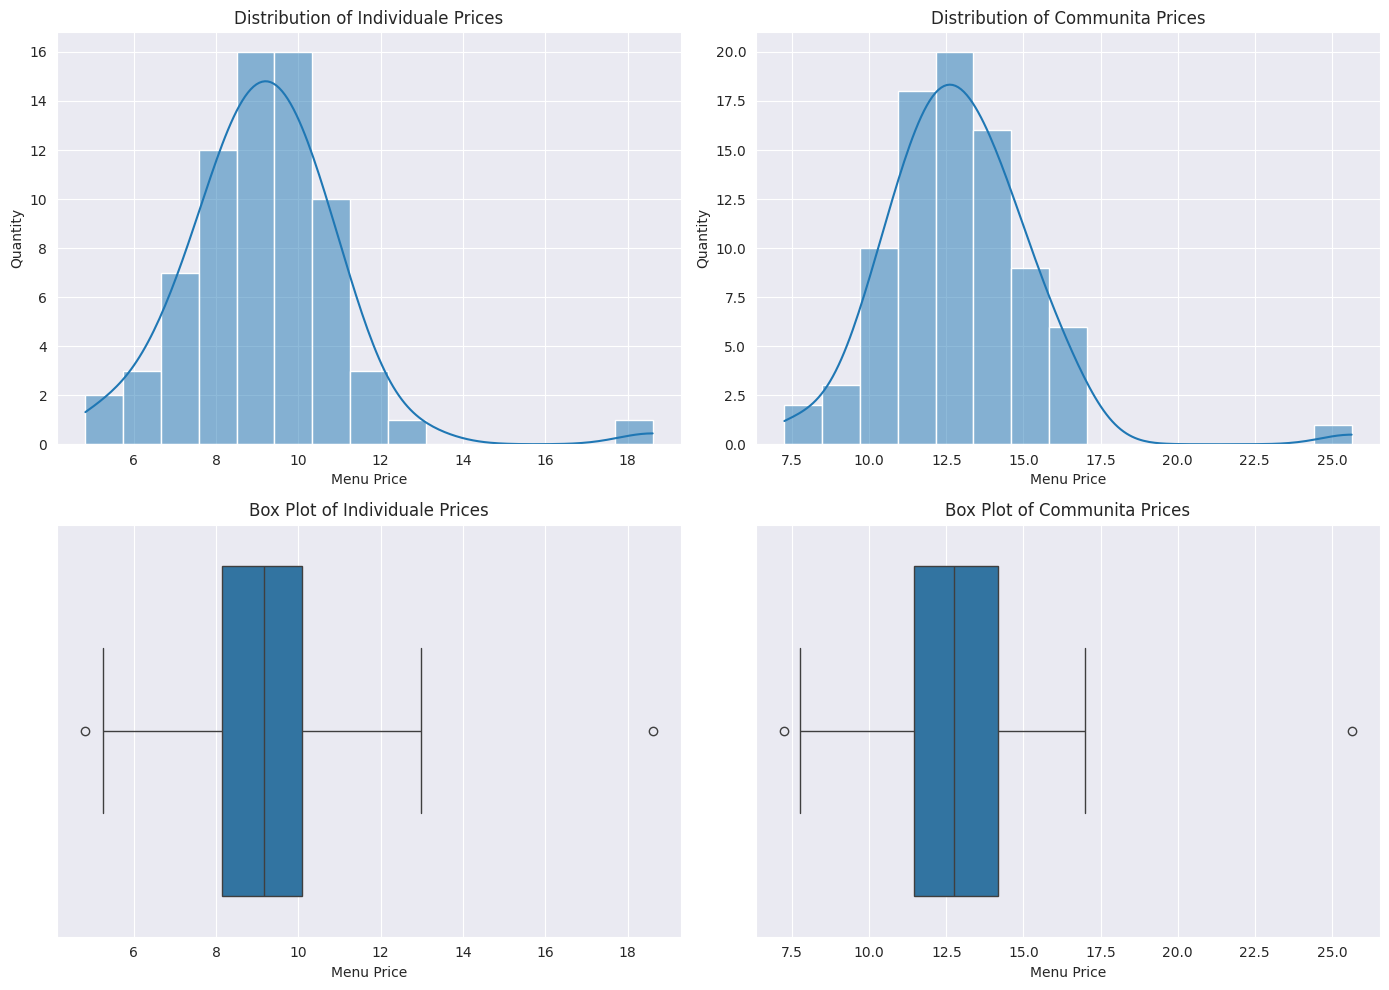

In [95]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
plot_distribution(df, 'Individuale', axes[0, 0])
plot_distribution(df, 'Communita', axes[0, 1])
plot_boxplot(df, 'Individuale', axes[1, 0])
plot_boxplot(df, 'Communita', axes[1, 1])
plt.tight_layout()
plt.savefig('eda.png')
plt.show()

### Insights from Distributions and Box Plots
The analysis of these plots are consistent with the statistics analysed earlier. Here are some key insights:

### Individuale Prices:
#### Distribution Plot:
- **Shape**: The distribution of Individuale prices is right-skewed.
- **Range**: Prices range from approximately 4.8 to 18.6.
- **Mode**: The most frequent prices fall between 9 and 10.
- **Outliers**: There are some noticeable outliers, particularly on the higher end above 18.

#### Box Plot:
- **Interquartile Range (IQR)**: The IQR extends from approximately 8 to 11.
- **Outliers**: Outliers are present beyond the whiskers, indicating prices below 6 and above 18 are rare compared to the rest of the data.

### Communita Prices:
#### Distribution Plot:
- **Shape**: The distribution of Communita prices is also right-skewed.
- **Range**: Prices range from approximately 7.25 to 25.64.
- **Mode**: The most frequent prices fall between 12 and 13.
- **Outliers**: Outliers are present, especially above 22.

#### Box Plot:
- **Interquartile Range (IQR)**: The IQR extends from approximately 11 to 14.
- **Outliers**: Outliers are present beyond the whiskers, indicating prices below 9 and above 20 are rare compared to the rest of the data.

### Summary:
- Both products show a right-skewed distribution, indicating that most prices are clustered at the lower end with fewer occurrences of higher prices.
- Outliers are more prominent on the higher end for both products.
- The IQR for Individuale is narrower than that for Communita, suggesting that Individuale prices are more tightly clustered around the median compared to Communita prices.
- The presence of outliers indicates that there are some pricing anomalies which may need further investigation or could be genuine high-value sales.

This analysis helps understand the pricing strategy and distribution, and indicates that both products have similar pricing patterns with some high-end outliers.

# Deal with Outliers
Identify and remove high side and low side outliers

In [96]:
def identify_outliers(df, column):
    """
     Identify outliers in a specified column of a DataFrame using the 
     Interquartile Range (IQR) method.
     
     The function calculates the first quartile (Q1) and the third quartile 
     (Q3) of the specified column. The interquartile range (IQR) is then 
     computed as the difference between Q3 and Q1.
    
     Outliers are defined as data points that fall below Q1 - 1.5 * IQR or 
     above Q3 + 1.5 * IQR. The function returns the rows containing these  
     outliers along with the calculated lower and upper bounds.

    :param df: 
    :param column: 
    :return: tuple: A tuple containing:
        - pandas.DataFrame: A DataFrame containing the rows identified as outliers.
        - float: The lower bound for identifying outliers.
        - float: The upper bound for identifying outliers.
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)], lower_bound, upper_bound

In [97]:
individuale_outliers, indiv_lower, indiv_upper = identify_outliers(df[df['Product'] == 'Individuale'], 'Menu_Price')
communita_outliers, comm_lower, comm_upper = identify_outliers(df[df['Product'] == 'Communita'], 'Menu_Price')

### Remove high-side outliers

In [98]:
data_no_outliers = df.drop(individuale_outliers[individuale_outliers['Menu_Price'] > indiv_upper].index)
data_no_outliers = data_no_outliers.drop(communita_outliers[communita_outliers['Menu_Price'] > comm_upper].index)

### Remove low-side outliers

In [99]:
final_df = data_no_outliers.drop(individuale_outliers[individuale_outliers['Menu_Price'] < indiv_lower].index)
final_df = final_df.drop(communita_outliers[communita_outliers['Menu_Price'] < comm_lower].index)

### Calculate statistics without outliers

In [100]:
individuale_stats_no_outliers = calculate_statistics(data_no_outliers[data_no_outliers['Product'] == 'Individuale'])
communita_stats_no_outliers = calculate_statistics(data_no_outliers[data_no_outliers['Product'] == 'Communita'])

### Display the statistics

In [101]:
print(f"Individuale Price Statistics without High Side Outliers:\n{individuale_stats_no_outliers}")
print(f"\nCommunita Price Statistics without High Side Outliers:\n{communita_stats_no_outliers}")

Individuale Price Statistics without High Side Outliers:
min          4.820000
mean         9.027321
max         12.990000
std          1.592352
skewness    -0.269937
kurtosis     0.122288
Name: Menu_Price, dtype: float64

Communita Price Statistics without High Side Outliers:
min          7.250000
mean        12.734881
max         16.990000
std          2.006031
skewness    -0.170001
kurtosis    -0.102913
Name: Menu_Price, dtype: float64


### Analysis of Price Statistics After Removing High Side Outliers

#### Individuale Price Statistics without High Side Outliers:
- **Min Price**: 4.82
- **Mean Price**: 9.03
- **Max Price**: 12.99
- **Standard Deviation**: 1.59
- **Skewness**: -0.27
- **Kurtosis**: 0.12

##### Observations:
- **Reduction in Mean**: The mean price has decreased from 9.16 to 9.03, indicating that the removal of high side outliers brought down the average price slightly.
- **Reduction in Standard Deviation**: The standard deviation has decreased from 1.95 to 1.59, suggesting that the prices are now less spread out and more consistent.
- **Change in Skewness**: The skewness has changed from positive (1.36) to slightly negative (-0.27), indicating a shift towards a more symmetrical distribution around the mean.
- **Change in Kurtosis**: The kurtosis has decreased significantly from 6.46 to 0.12, indicating a reduction in the presence of extreme values, leading to a more normal distribution.

#### Communita Price Statistics without High Side Outliers:
- **Min Price**: 7.25
- **Mean Price**: 12.73
- **Max Price**: 16.99
- **Standard Deviation**: 2.01
- **Skewness**: -0.17
- **Kurtosis**: -0.10

##### Observations:
- **Reduction in Mean**: The mean price has decreased from 12.89 to 12.73, showing a slight reduction in the average price after removing high side outliers.
- **Reduction in Standard Deviation**: The standard deviation has decreased from 2.44 to 2.01, suggesting a decrease in price variability.
- **Change in Skewness**: The skewness has changed from positive (1.50) to slightly negative (-0.17), indicating a more symmetrical distribution around the mean.
- **Change in Kurtosis**: The kurtosis has decreased from 7.40 to -0.10, indicating a significant reduction in the presence of extreme values, leading to a more normal distribution.

### Summary:
- **Effect on Distribution**: Removing high side outliers has made both distributions more symmetrical and closer to a normal distribution.
- **Consistency**: The reduction in standard deviation for both products indicates that prices are now more consistent.
- **Normalization**: The change in skewness and kurtosis towards values closer to zero suggests that the price distributions are now more normalized, reducing the impact of extreme values.

This analysis indicates that the removal of high side outliers has resulted in more consistent and normally distributed prices for both Individuale and Communita products. This should help in creating more reliable and accurate models for price elasticity and profitability analysis.

# Create seperate dataframes for each product

In [102]:
individuale_df = final_df[final_df['Product'] == 'Individuale'].copy()
communita_df = final_df[final_df['Product'] == 'Communita'].copy()

# PED on untransformed data

### Scatter plot for Price vs. Pizza Count

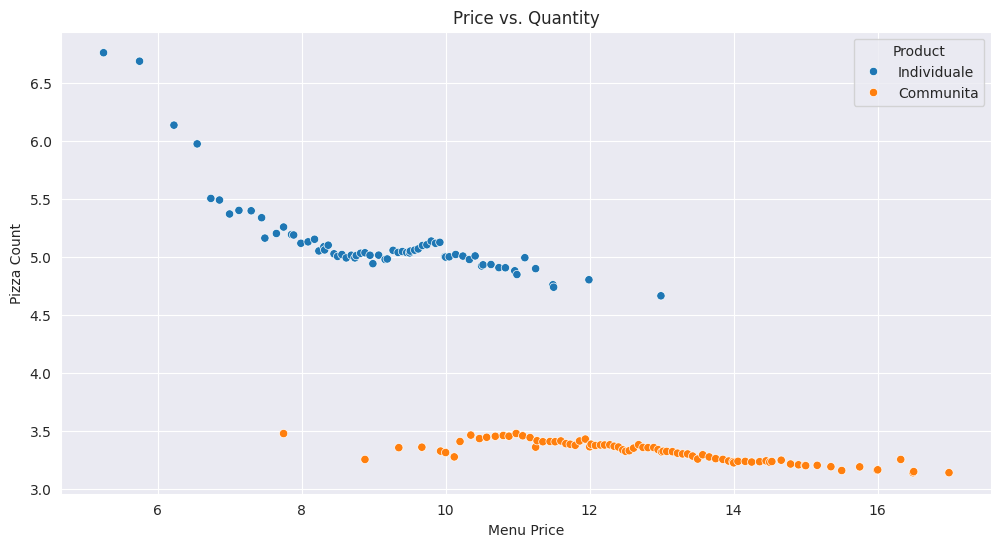

In [103]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=final_df, 
    x='Menu_Price', 
    y='Pizza_Count', 
    hue='Product'
)
plt.title('Price vs. Quantity')
plt.xlabel('Menu Price')
plt.ylabel('Pizza Count')
plt.legend(title='Product')
plt.savefig('./../plots/price_vs_pizza_count.png')
plt.show()

This scatter plot illustrates the relationship between `Menu Price` and `Pizza Count` for two different products, Individuale (blue) and Communita (orange). Here’s the analysis of the plot:

### Analysis

#### 1. **Inverse Relationship Between Price and Quantity:**
   - **Individuale (blue dots):** There is a clear inverse relationship between `Menu Price` and `Pizza Count`. As the price increases, the quantity sold decreases. This suggests price elasticity of demand for Individuale, where higher prices lead to lower sales volumes.
   - **Communita (orange dots):** Similarly, Communita also shows an inverse relationship between price and quantity, although it appears less steep than Individuale. This might indicate that Communita is less price-sensitive compared to Individuale.

#### 2. **Price Range and Sales Volume:**
   - **Individuale:** The price range for Individuale is between approximately 5 to 13, with the quantity sold ranging from about 6.5 down to around 3.
   - **Communita:** The price range for Communita is higher, between 9 to 16, and the quantity sold ranges from about 3.5 to 3. 

#### 3. **Different Sensitivity:**
   - The difference in the steepness of the decline in sales with increasing prices suggests that Individuale might be more sensitive to price changes than Communita. 

#### 4. **Data Distribution:**
   - **Individuale:** There is a wider spread of prices and corresponding quantities sold, indicating that there is more variation in how Individuale is priced and how its sales respond to these prices.
   - **Communita:** The data points are more clustered, indicating a more consistent pricing and sales pattern.

### Implications for Pricing Strategy

#### 1. **Targeted Pricing:**
   - For Individuale, more careful consideration might be needed when adjusting prices, as small increases in price could lead to significant drops in sales volume.
   - For Communita, the pricing strategy could potentially be more flexible, as it appears less sensitive to price changes.

#### 2. **Profit Maximization:**
   - The business could use this information to set prices that balance between maximizing profit per unit and total sales volume. Given that Individuale is more price-sensitive, finding the optimal price point will be crucial.

#### 3. **Further Analysis:**
   - Further statistical analysis, such as calculating the price elasticity of demand quantitatively, would provide more precise insights into how sensitive each product is to price changes.

### Next Steps

- **Calculate Price Elasticity of Demand:** For both products, to quantify the sensitivity of sales volume to price changes.
- **Explore Other Variables:** Consider how other factors like promotions, seasonality, or customer demographics might influence sales.
- **Profit Optimization Models:** Use the insights gained to develop pricing models aimed at maximizing total profit, taking into account both the profit per unit and the total volume sold.

By understanding the nuanced relationship between price and quantity for each product, the business can make more informed decisions to optimize pricing strategies and maximize profitability.

### price vs profit

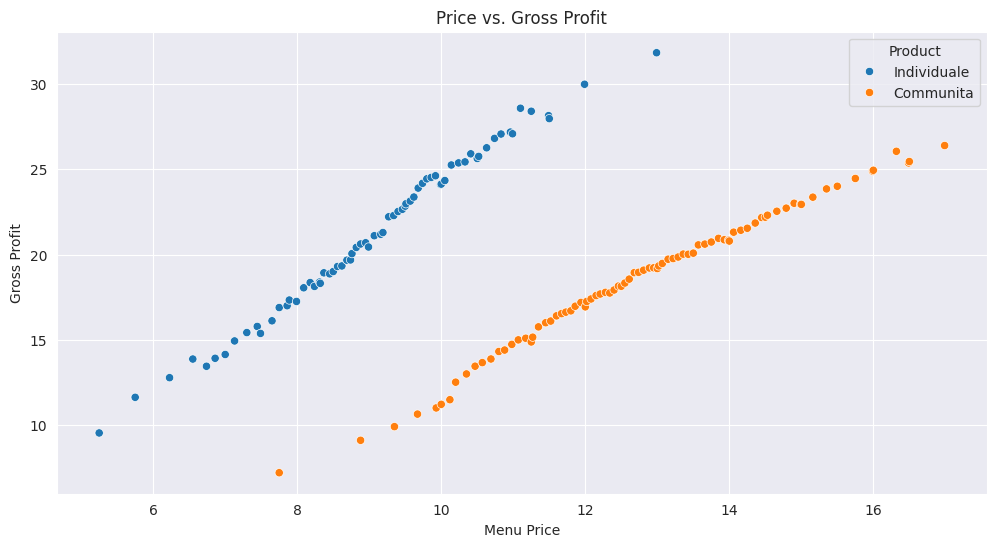

In [104]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=final_df, 
    x='Menu_Price', 
    y='gross_profit', 
    hue='Product'
)
plt.title('Price vs. Gross Profit')
plt.xlabel('Menu Price')
plt.ylabel('Gross Profit')
plt.legend(title='Product')
# plt.savefig('price_vs_profit_percentage.png')
plt.show()

### Analysis of Price vs. Gross Profit Plot

#### 1. **Positive Relationship Between Price and Gross Profit:**
   - **Individuale (blue dots):** There is a clear positive relationship between `Menu Price` and `Gross Profit`. As the price increases, the gross profit also increases. This indicates that higher prices lead to higher profits, assuming the sales volume remains consistent.
   - **Communita (orange dots):** Similarly, Communita shows a positive relationship between price and gross profit, though it appears less steep compared to Individuale. This suggests that while higher prices still lead to higher profits, the rate of increase is slower for Communita.

#### 2. **Different Profit Margins:**
   - **Individuale:** The gross profit ranges from around 10 to over 30 as the price increases from 5 to 13. This wider range indicates potentially higher profit margins for Individuale.
   - **Communita:** The gross profit ranges from around 10 to 25 as the price increases from 9 to 16. This narrower range suggests lower profit margins compared to Individuale.

#### 3. **Data Distribution:**
   - **Individuale:** The data points for Individuale are more spread out, suggesting a wider range of pricing strategies and corresponding profits.
   - **Communita:** The data points for Communita are more clustered, indicating more consistent pricing and profit patterns.

### Implications for Pricing Strategy

#### 1. **Maximizing Gross Profit:**
   - **Individuale:** The business can experiment with higher prices to see if the increased gross profit outweighs any potential loss in sales volume. The steep increase in profit suggests a strong potential for higher margins.
   - **Communita:** While the profit increases with price, the slower rate suggests that there may be an optimal price point beyond which further increases yield diminishing returns.

#### 2. **Profit Margin Optimization:**
   - **Individuale:** The wide range of gross profits suggests significant variability in profit margins. The business can explore ways to optimize costs or increase prices to maximize these margins.
   - **Communita:** The narrower range of gross profits indicates more stable profit margins. The focus should be on maintaining this stability while exploring incremental price increases to boost overall profit.

#### 3. **Further Analysis:**
   - **Elasticity:** Conduct a detailed analysis of price elasticity to understand how changes in price impact overall profit.
   - **Cost Analysis:** Investigate the cost structures for both products to identify areas for cost reduction, further enhancing profit margins.

### Next Steps

1. **Price Elasticity Calculation:**
   - Calculate the price elasticity of demand for both products to quantify the sensitivity of sales volume to price changes.

2. **Profit Optimization Models:**
   - Develop pricing models that consider both the gross profit and the impact of price changes on sales volume to find the optimal pricing strategy.

3. **Cost Management:**
   - Analyze and manage the cost per unit for each product to maximize gross profit.

By leveraging these insights, the business can refine its pricing strategies to optimize gross profit while considering the unique characteristics of each product.

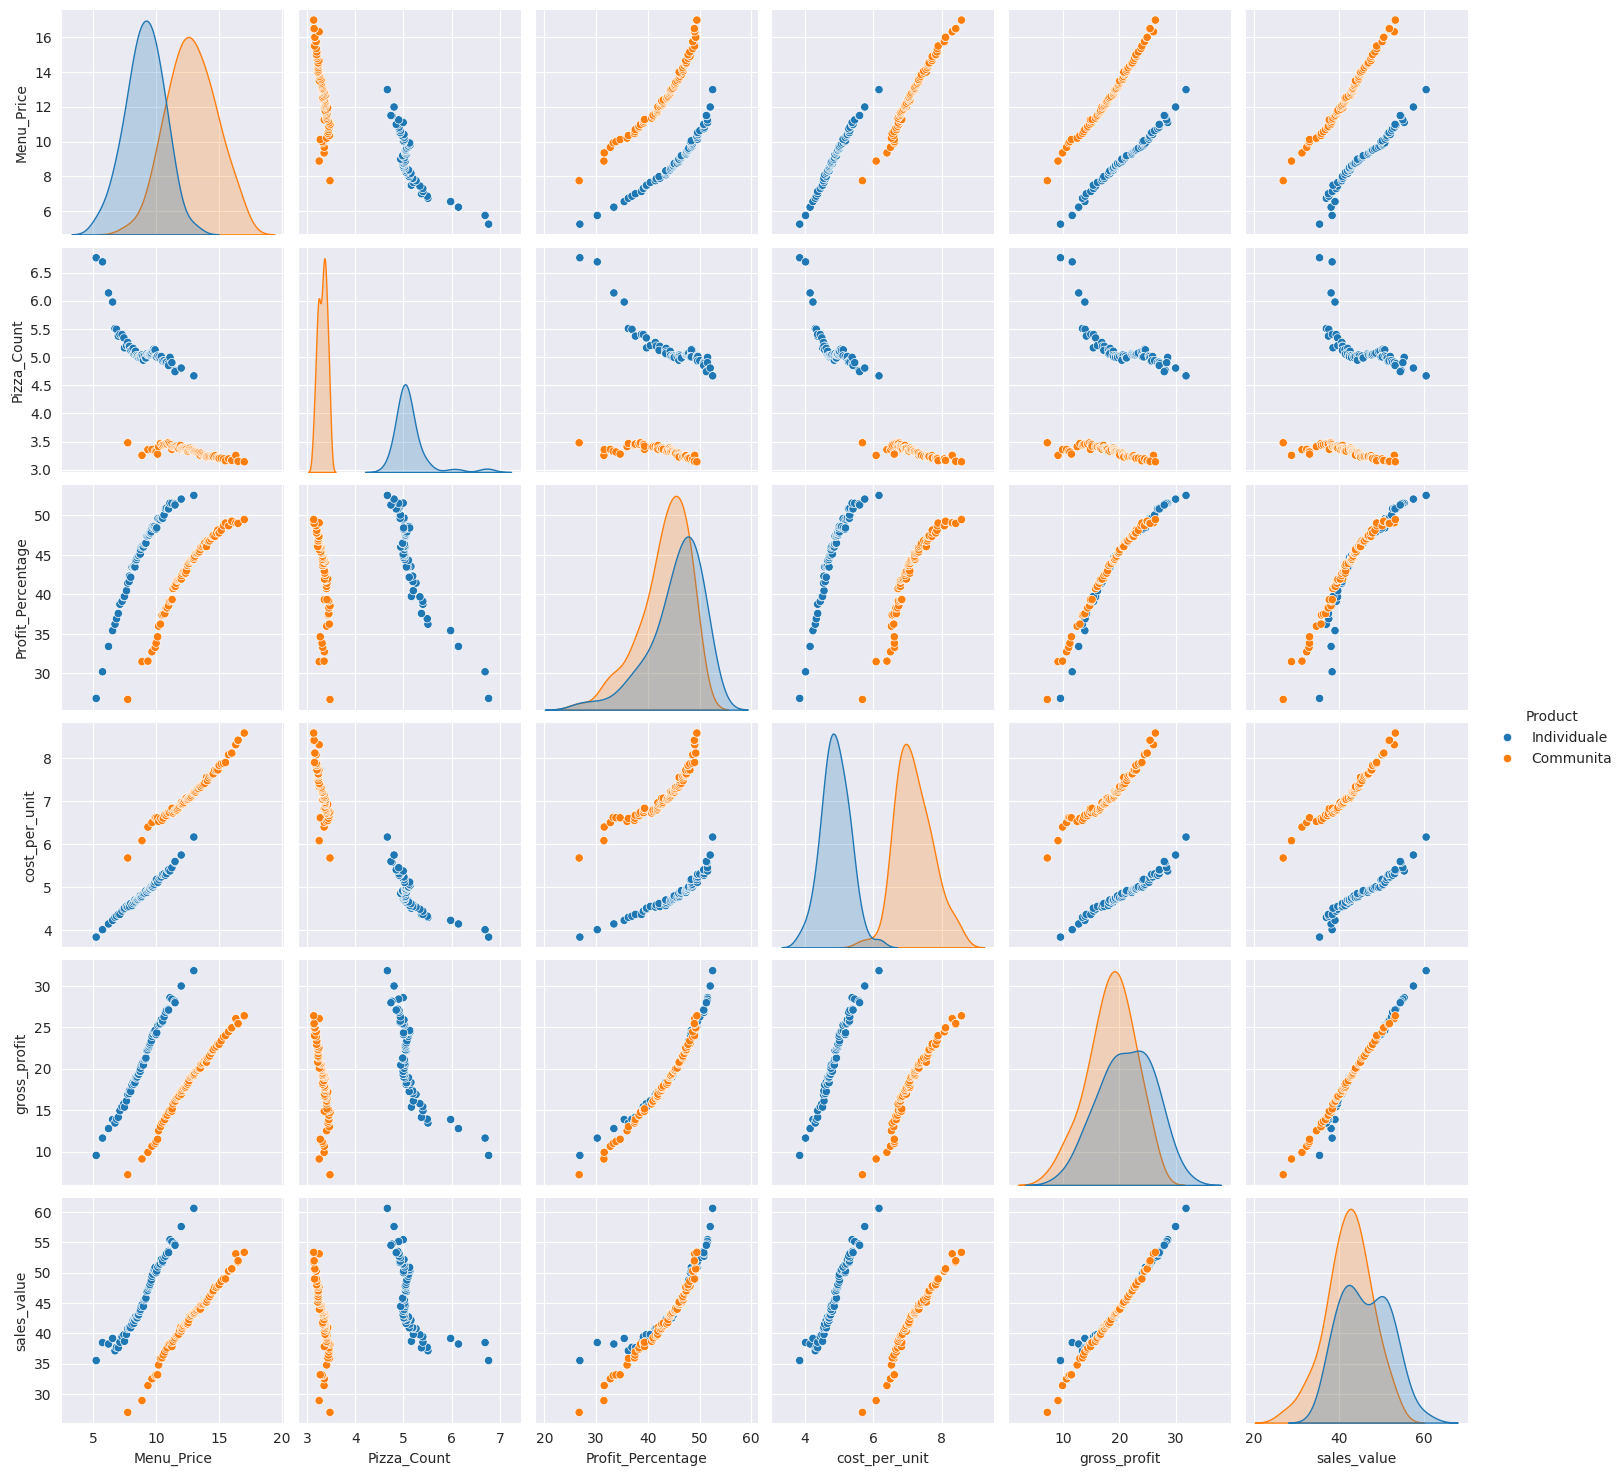

In [105]:
# pairplot
sns.pairplot(final_df, hue='Product')
plt.show()

### Pair Plot Analysis

#### Overview
The pair plot visualizes the relationships between various features for two products, Individuale (blue) and Communita (orange). Each diagonal shows the distribution of the variables, while the off-diagonal plots show the relationships between pairs of variables.

### Key Insights

#### 1. **Menu Price vs. Other Variables:**
   - **Menu Price vs. Pizza Count:** For both products, there's a negative relationship. As the menu price increases, the number of pizzas sold decreases, indicating price sensitivity.
   - **Menu Price vs. Profit Percentage:** There is a strong positive relationship for both products, suggesting that higher menu prices are associated with higher profit percentages.
   - **Menu Price vs. Cost per Unit:** Positive relationship for both products, implying that higher menu prices correlate with higher costs per unit.
   - **Menu Price vs. Gross Profit:** Positive relationship, indicating that higher menu prices lead to higher gross profits, which aligns with the earlier analysis.

#### 2. **Pizza Count vs. Other Variables:**
   - **Pizza Count vs. Profit Percentage:** There is a negative relationship. Higher profit percentages correspond to lower pizza counts, suggesting that as the profit margin increases, the volume of sales decreases.
   - **Pizza Count vs. Cost per Unit:** There is no clear relationship observed.
   - **Pizza Count vs. Gross Profit:** Negative relationship, indicating that higher sales volumes correspond to lower gross profits per unit, reflecting lower profit margins.

#### 3. **Profit Percentage vs. Other Variables:**
   - **Profit Percentage vs. Cost per Unit:** Positive relationship, indicating that higher costs per unit are associated with higher profit percentages.
   - **Profit Percentage vs. Gross Profit:** Positive relationship, suggesting that higher profit percentages lead to higher gross profits.

#### 4. **Cost per Unit vs. Gross Profit:**
   - Positive relationship, indicating that higher costs per unit are associated with higher gross profits. This could imply that higher quality (and thus higher cost) ingredients or products lead to higher sales prices and profits.

### Product-Specific Observations

#### **Individuale (Blue):**
   - The relationships are generally more dispersed, indicating greater variability in menu prices, costs, and profits.
   - The distributions show that Individuale has a wider range of prices and costs, suggesting more flexibility in pricing strategies.

#### **Communita (Orange):**
   - The relationships are more tightly clustered, suggesting more consistent pricing, costs, and profits.
   - The distributions are narrower, indicating less variability and potentially more stability in pricing and profit margins.

### Implications for Strategy

1. **Pricing Strategy:**
   - Both products show that increasing prices can lead to higher gross profits, but the impact on sales volume (pizza count) must be considered.
   - For Individuale, the wider variability in data suggests more flexibility in experimenting with different pricing strategies.

2. **Cost Management:**
   - The positive relationship between cost per unit and gross profit suggests that investing in higher quality (and higher cost) products can lead to higher prices and profits.
   - Monitoring and managing costs effectively is crucial to maintaining profit margins.

3. **Profit Maximization:**
   - Focus on optimizing the balance between menu price and pizza count to maximize gross profit.
   - For Communita, maintain consistent pricing strategies that have been effective, while for Individuale, explore different pricing tiers to find optimal profit points.

### Conclusion
The pair plot provides valuable insights into the relationships between key variables for both products. By understanding these relationships, more informed decisions can be made regarding pricing strategies, cost management, and profit maximization. The differences between Individuale and Communita suggest that tailored strategies should be applied to each product to optimize their respective performances.

# Correlation analysis on untransformed data

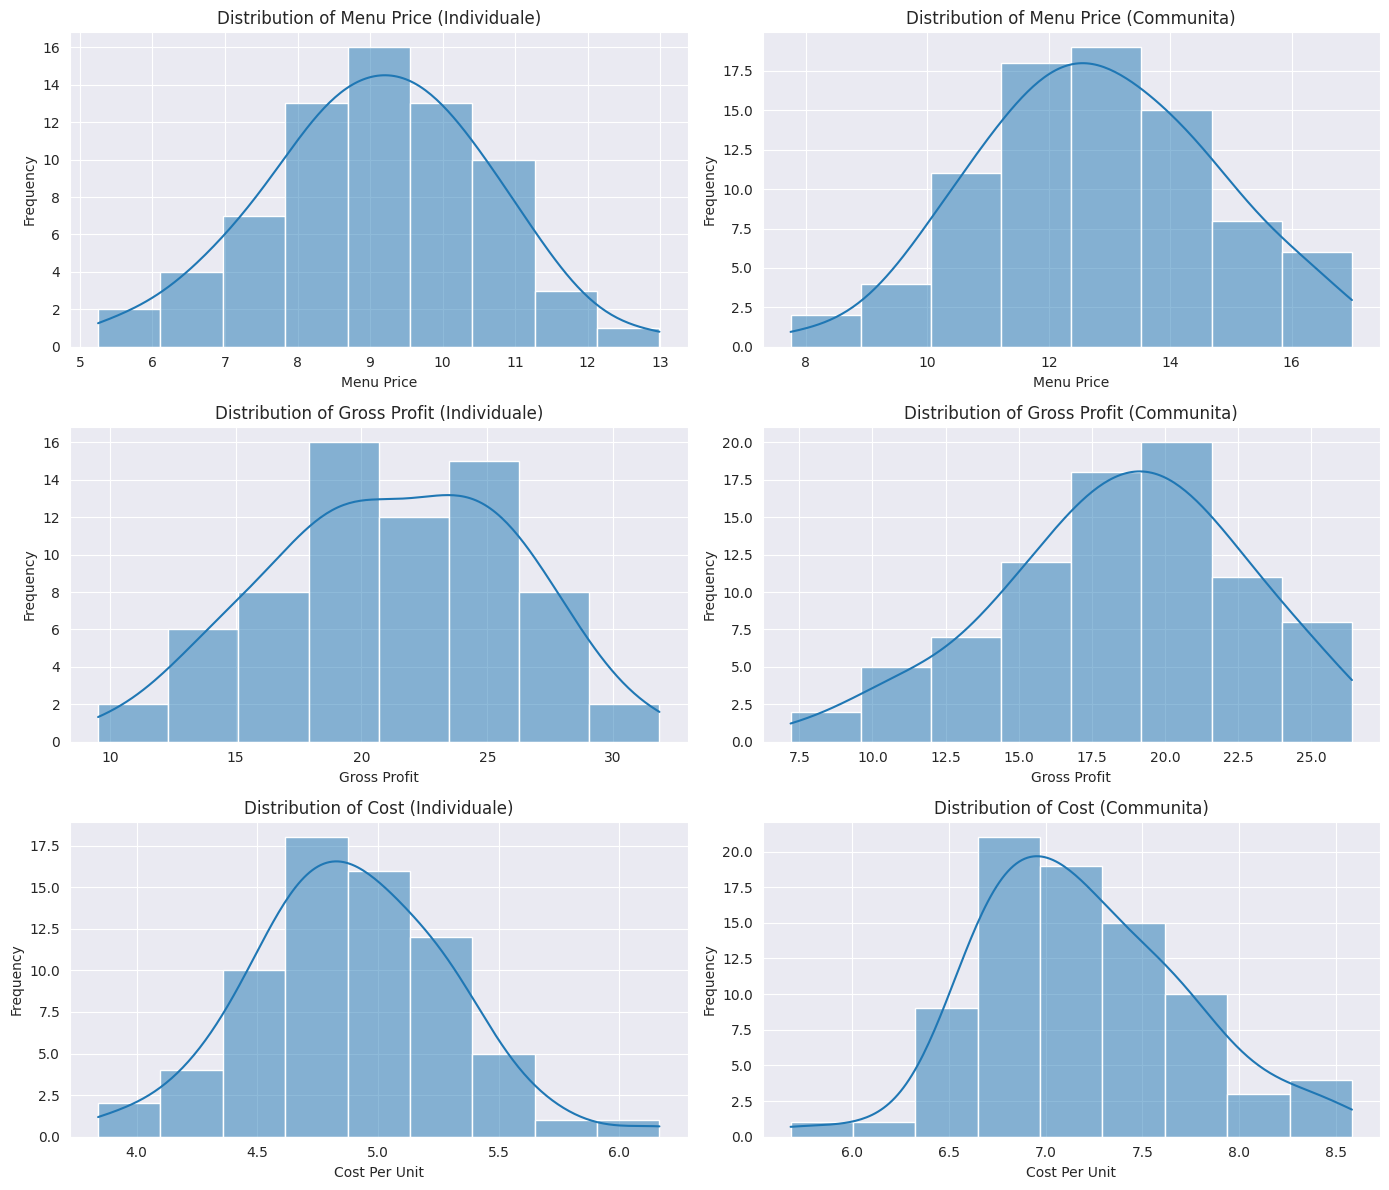

In [106]:
# Plot the distribution of Menu_Price, gross_profit, and cost_per_unit for each product, on the untransformed data
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# Individuale
sns.histplot(individuale_df['Menu_Price'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Menu Price (Individuale)')
axes[0, 0].set_xlabel('Menu Price')
axes[0, 0].set_ylabel('Frequency')

sns.histplot(individuale_df['gross_profit'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Gross Profit (Individuale)')
axes[1, 0].set_xlabel('Gross Profit')
axes[1, 0].set_ylabel('Frequency')

sns.histplot(individuale_df['cost_per_unit'], kde=True, ax=axes[2, 0])
axes[2, 0].set_title('Distribution of Cost (Individuale)')
axes[2, 0].set_xlabel('Cost Per Unit')
axes[2, 0].set_ylabel('Frequency')

# Communita
sns.histplot(communita_df['Menu_Price'], kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Menu Price (Communita)')
axes[0, 1].set_xlabel('Menu Price')
axes[0, 1].set_ylabel('Frequency')

sns.histplot(communita_df['gross_profit'], kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Gross Profit (Communita)')
axes[1, 1].set_xlabel('Gross Profit')
axes[1, 1].set_ylabel('Frequency')

sns.histplot(communita_df['cost_per_unit'], kde=True, ax=axes[2, 1])
axes[2, 1].set_title('Distribution of Cost (Communita)')
axes[2, 1].set_xlabel('Cost Per Unit')
axes[2, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### Analysis of Distribution Plots

#### Overview
These plots show the distributions of three key variables—Menu Price, Gross Profit, and Cost per Unit—for two products: Individuale and Communita. The plots include histograms and KDE (Kernel Density Estimation) lines to visualize the distribution shapes.

### Individuale

#### 1. **Menu Price:**
   - **Distribution:** The menu price for Individuale is roughly normally distributed with a slight right skew.
   - **Mean and Spread:** The central tendency appears around 9 with a spread from 5 to 13.
   - **Implications:** There is some variability in the pricing of Individuale, indicating that prices have been adjusted within this range.

#### 2. **Gross Profit:**
   - **Distribution:** The gross profit for Individuale shows a bimodal distribution, with peaks around 20 and 30.
   - **Mean and Spread:** The gross profit ranges between 10 and 35, indicating that different pricing strategies have led to varying profitability levels.
   - **Implications:** The bimodal distribution suggests the presence of two distinct pricing strategies or product variations within Individuale.

#### 3. **Cost per Unit:**
   - **Distribution:** The cost per unit for Individuale is approximately normally distributed.
   - **Mean and Spread:** The costs are centered around 4.5 to 5.5.
   - **Implications:** The consistent cost per unit suggests stable production costs, which is beneficial for profit margin calculations.

### Communita

#### 1. **Menu Price:**
   - **Distribution:** The menu price for Communita is also normally distributed with a slight right skew.
   - **Mean and Spread:** The prices are centered around 13, with a range from 8 to 17.
   - **Implications:** Communita prices are generally higher than Individuale, indicating a potential premium product positioning.

#### 2. **Gross Profit:**
   - **Distribution:** The gross profit for Communita is normally distributed.
   - **Mean and Spread:** The gross profit ranges from 7.5 to 25, with a mean around 17 to 20.
   - **Implications:** The normal distribution suggests consistent profitability without distinct modes, unlike Individuale.

#### 3. **Cost per Unit:**
   - **Distribution:** The cost per unit for Communita is normally distributed but with a slightly wider spread than Individuale.
   - **Mean and Spread:** The costs are centered around 6.5 to 8.
   - **Implications:** Higher costs per unit compared to Individuale suggest that Communita might use more expensive ingredients or processes, supporting its higher pricing strategy.

### Comparative Insights

1. **Pricing Strategy:**
   - **Individuale:** Shows more variability in both menu price and gross profit, indicating a broader pricing strategy.
   - **Communita:** Has higher and more consistent pricing, which is reflected in its cost per unit and gross profit distributions.

2. **Cost Management:**
   - **Individuale:** Lower cost per unit, more variability in pricing and profit.
   - **Communita:** Higher cost per unit but consistent pricing and profit, potentially reflecting a premium positioning.

3. **Profitability:**
   - **Individuale:** Bimodal distribution of gross profit suggests different strategies or product versions influencing profitability.
   - **Communita:** Consistent gross profit distribution aligns with its stable pricing and higher costs.

### Conclusion
The distribution plots provide valuable insights into the pricing, cost, and profitability strategies for Individuale and Communita. Individuale shows more variability, indicating a flexible pricing strategy, while Communita appears to be positioned as a premium product with consistent higher pricing and costs. Understanding these distributions helps in making informed decisions regarding pricing strategies, cost management, and profit optimisation for each product.

# Check skewness of the original data for each product

In [107]:
print(f"Skewness of Profit Dollars (Individuale): {individuale_df['Menu_Price'].skew()}")
print(f"Skewness of Profit Dollars (Individuale): {individuale_df['gross_profit'].skew()}")
print(f"Skewness of Cost (Individuale): {individuale_df['cost_per_unit'].skew()}")

print(f"Skewness of Profit ($) (Communita): {communita_df['gross_profit'].skew()}")
print(f"Skewness of Cost (Communita): {communita_df['cost_per_unit'].skew()}")

Skewness of Profit Dollars (Individuale): -0.124856322032253
Skewness of Profit Dollars (Individuale): -0.17231620173244405
Skewness of Cost (Individuale): 0.1883666681980626
Skewness of Profit ($) (Communita): -0.3824934234576808
Skewness of Cost (Communita): 0.3233467318301173


### Skewness Analysis

#### Overview
Skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean. A negative skewness indicates that the tail on the left side of the probability distribution is longer or fatter than the right side. Conversely, a positive skewness indicates that the tail on the right side is longer or fatter than the left side. A skewness close to zero suggests a symmetric distribution.

### Individuale

#### 1. **Skewness of Profit Dollars (First Value): -0.124856322032253**
   - **Interpretation:** This skewness value is close to zero, indicating that the distribution of profit dollars is nearly symmetric. There is a slight left skew, meaning there are more high-value outliers.

#### 2. **Skewness of Profit Dollars (Second Value): -0.17231620173244405**
   - **Interpretation:** This value is also close to zero but slightly more negative than the first. It confirms that the distribution remains nearly symmetric with a minor left skew, suggesting a few high-value outliers in the dataset.

#### 3. **Skewness of Cost: 0.1883666681980626**
   - **Interpretation:** This positive skewness value indicates a slight right skew in the distribution of costs. This suggests that there are a few high-cost outliers in the dataset.

### Communita

#### 1. **Skewness of Profit ($): -0.3824934234576808**
   - **Interpretation:** This negative skewness value indicates a moderate left skew in the distribution of profit dollars. This means there are more high-value outliers, which could indicate a few instances of significantly higher profits compared to the average.

#### 2. **Skewness of Cost: 0.3233467318301173**
   - **Interpretation:** This positive skewness value suggests a right skew in the cost distribution. This implies there are some high-cost outliers, indicating variability in the cost structure for Communita.

### Comparative Insights

1. **Profit Dollars for Individuale:**
   - The two skewness values for profit dollars in Individuale are very similar and close to zero. This suggests a stable, nearly symmetric distribution of profit dollars with a slight tendency towards higher outliers.

2. **Cost for Individuale:**
   - The positive skewness indicates a slight right skew, showing some high-cost outliers. This is consistent with a cost structure that occasionally includes higher-than-average costs.

3. **Profit Dollars for Communita:**
   - The skewness value is more negative compared to Individuale, indicating a stronger left skew. This means there are relatively more high-profit outliers in Communita, suggesting some instances of significantly higher profitability.

4. **Cost for Communita:**
   - The positive skewness value shows a right skew in costs, indicating some high-cost outliers. The skewness is higher than that of Individuale, suggesting more variability in the cost structure of Communita.

### Conclusion
The skewness values provide insights into the distribution shapes of profit dollars and costs for both products. Individuale has a nearly symmetric profit distribution with slight high-value outliers, while Communita shows a stronger tendency towards high-profit outliers. Both products exhibit some degree of right skew in costs, indicating high-cost outliers. These insights are crucial for understanding the underlying distribution characteristics and making informed decisions regarding pricing, cost management, and profitability strategies.

# Transformation and visualisation
in order to find the transformation that best suits this dataset we'll compare 13 different methods

In [108]:
# Define a function to apply transformations and calculate skewness and kurtosis
def calculate_transformations_stats(df, feature):
    """
    Calculate skewness and kurtosis for different transformations of a feature, for the purpose of finding the best transformation method
    :param df: 
    :param feature: 
    :return: 
    """
    results = {}
    
    # Original
    results['Original'] = (skew(df[feature]), kurtosis(df[feature]))
    
    # Log transformation
    df['Log'] = np.log(df[feature] + 1)
    results['Log'] = (skew(df['Log']), kurtosis(df['Log']))
    
    # Box-Cox transformation
    df['BoxCox'], _ = boxcox(df[feature] + 1)
    results['BoxCox'] = (skew(df['BoxCox']), kurtosis(df['BoxCox']))
    
    # Yeo-Johnson transformation
    pt = PowerTransformer(method='yeo-johnson')
    df['YeoJohnson'] = pt.fit_transform(df[[feature]])
    results['YeoJohnson'] = (skew(df['YeoJohnson']), kurtosis(df['YeoJohnson']))
    
    # Square Root transformation
    df['Sqrt'] = np.sqrt(df[feature])
    results['Sqrt'] = (skew(df['Sqrt']), kurtosis(df['Sqrt']))
    
    # Reciprocal transformation
    df['Reciprocal'] = 1 / (df[feature] + 1)
    results['Reciprocal'] = (skew(df['Reciprocal']), kurtosis(df['Reciprocal']))
    
    # Exponential transformation
    df['Exponential'] = np.exp(df[feature])
    results['Exponential'] = (skew(df['Exponential']), kurtosis(df['Exponential']))
    
    # Robust Scaler
    scaler = RobustScaler()
    df['Robust'] = scaler.fit_transform(df[[feature]])
    results['Robust'] = (skew(df['Robust']), kurtosis(df['Robust']))
    
    # Quantile Transformation
    qt = QuantileTransformer(output_distribution='normal')
    df['Quantile'] = qt.fit_transform(df[[feature]])
    results['Quantile'] = (skew(df['Quantile']), kurtosis(df['Quantile']))
    
    # Rank Transformation
    df['Rank'] = df[feature].rank()
    results['Rank'] = (skew(df['Rank']), kurtosis(df['Rank']))
    
    # Inverse Transformation
    df['Inverse'] = 1 / (df[feature] + 1)
    results['Inverse'] = (skew(df['Inverse']), kurtosis(df['Inverse']))
    
    # Sigmoid Transformation
    df['Sigmoid'] = 1 / (1 + np.exp(-df[feature]))
    results['Sigmoid'] = (skew(df['Sigmoid']), kurtosis(df['Sigmoid']))
    
    # Z-Score Normalization
    scaler = StandardScaler()
    df['ZScore'] = scaler.fit_transform(df[[feature]])
    results['ZScore'] = (skew(df['ZScore']), kurtosis(df['ZScore']))
    
    # Min-Max Scaling
    scaler = MinMaxScaler()
    df['MinMax'] = scaler.fit_transform(df[[feature]])
    results['MinMax'] = (skew(df['MinMax']), kurtosis(df['MinMax']))
    
    # Binning
    df['Binned'] = pd.cut(df[feature], bins=10, labels=False)
    results['Binned'] = (skew(df['Binned']), kurtosis(df['Binned']))
    
    return results

In [109]:
# Calculate and print the skewness and kurtosis for each transformation
for product_df, product_name in zip([individuale_df, communita_df], ['Individuale', 'Communita']):
    print(f"--- {product_name} ---")
    for feature in ['gross_profit', 'cost_per_unit']:
        print(f"\nFeature: {feature}")
        stats = calculate_transformations_stats(product_df.copy(), feature)
        for transform, (skewness, kurt) in stats.items():
            print(f"{transform}: Skewness = {skewness:.4f}, Kurtosis = {kurt:.4f}")

--- Individuale ---

Feature: gross_profit
Original: Skewness = -0.1685, Kurtosis = -0.5697
Log: Skewness = -0.7013, Kurtosis = 0.2088
BoxCox: Skewness = -0.0620, Kurtosis = -0.6190
YeoJohnson: Skewness = -0.0620, Kurtosis = -0.6190
Sqrt: Skewness = -0.4352, Kurtosis = -0.2862
Reciprocal: Skewness = 1.3836, Kurtosis = 2.4173
Exponential: Skewness = 7.8187, Kurtosis = 60.4751
Robust: Skewness = -0.1685, Kurtosis = -0.5697
Quantile: Skewness = 0.0000, Kurtosis = 5.4822
Rank: Skewness = 0.0000, Kurtosis = -1.2005
Inverse: Skewness = 1.3836, Kurtosis = 2.4173
Sigmoid: Skewness = -7.9283, Kurtosis = 61.7735
ZScore: Skewness = -0.1685, Kurtosis = -0.5697
MinMax: Skewness = -0.1685, Kurtosis = -0.5697
Binned: Skewness = -0.1721, Kurtosis = -0.7338

Feature: cost_per_unit
Original: Skewness = 0.1842, Kurtosis = 0.5506
Log: Skewness = -0.0739, Kurtosis = 0.4457
BoxCox: Skewness = 0.0032, Kurtosis = 0.4552
YeoJohnson: Skewness = 0.0032, Kurtosis = 0.4552
Sqrt: Skewness = 0.0281, Kurtosis = 0.465

/home/noone/.cache/pypoetry/virtualenvs/dominos-senior-data-scientist-mPMyyBsO-py3.11/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (69). n_quantiles is set to n_samples.
  warnings.warn(
/home/noone/.cache/pypoetry/virtualenvs/dominos-senior-data-scientist-mPMyyBsO-py3.11/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (69). n_quantiles is set to n_samples.
  warnings.warn(
/home/noone/.cache/pypoetry/virtualenvs/dominos-senior-data-scientist-mPMyyBsO-py3.11/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (83). n_quantiles is set to n_samples.
  warnings.warn(
/home/noone/.cache/pypoetry/virtualenvs/dominos-senior-data-scientist-mPMyyBsO-py3.11/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:27

### Analysis of Skewness and Kurtosis for Different Transformations

#### Gross Profit

##### Individuale

1. **Original:**
   - **Skewness:** -0.1685 (Slight left skew, nearly symmetric)
   - **Kurtosis:** -0.5697 (Platykurtic, flatter than normal distribution)

2. **Log:**
   - **Skewness:** -0.7013 (Moderate left skew, more pronounced than original)
   - **Kurtosis:** 0.2088 (Closer to normal distribution, slightly more peaked)

3. **BoxCox:**
   - **Skewness:** -0.0620 (Closer to zero, almost symmetric)
   - **Kurtosis:** -0.6190 (Slightly flatter than original)

4. **YeoJohnson:**
   - Similar to BoxCox.

5. **Sqrt:**
   - **Skewness:** -0.4352 (Moderate left skew)
   - **Kurtosis:** -0.2862 (Closer to normal distribution)

6. **Reciprocal:**
   - **Skewness:** 1.3836 (Strong right skew)
   - **Kurtosis:** 2.4173 (Leptokurtic, more peaked and heavy-tailed)

7. **Exponential:**
   - **Skewness:** 7.8187 (Very strong right skew)
   - **Kurtosis:** 60.4751 (Extremely leptokurtic)

8. **Robust, ZScore, MinMax:**
   - Similar to original data, as these transformations standardize or scale the data without significantly altering the distribution shape.

9. **Quantile, Rank:**
   - **Skewness:** 0.0000 (Perfectly symmetric)
   - **Kurtosis:** 5.4822 (Leptokurtic for Quantile, Platykurtic for Rank)

10. **Sigmoid:**
    - **Skewness:** -7.9283 (Very strong left skew)
    - **Kurtosis:** 61.7735 (Extremely leptokurtic)

11. **Binned:**
    - **Skewness:** -0.1721 (Slight left skew, similar to original)
    - **Kurtosis:** -0.7338 (Flatter than original)

##### Communita

1. **Original:**
   - **Skewness:** -0.3755 (Moderate left skew)
   - **Kurtosis:** -0.2064 (Slightly platykurtic)

2. **Log:**
   - **Skewness:** -1.0407 (More pronounced left skew)
   - **Kurtosis:** 1.2206 (Leptokurtic)

3. **BoxCox:**
   - **Skewness:** -0.0666 (Almost symmetric)
   - **Kurtosis:** -0.4759 (Closer to normal distribution)

4. **YeoJohnson:**
   - Similar to BoxCox.

5. **Sqrt:**
   - **Skewness:** -0.7084 (Moderate left skew)
   - **Kurtosis:** 0.3671 (Closer to normal distribution)

6. **Reciprocal:**
   - **Skewness:** 1.9150 (Strong right skew)
   - **Kurtosis:** 4.8412 (Leptokurtic)

7. **Exponential:**
   - **Skewness:** 4.8118 (Very strong right skew)
   - **Kurtosis:** 24.7839 (Extremely leptokurtic)

8. **Robust, ZScore, MinMax:**
   - Similar to original data.

9. **Quantile, Rank:**
   - **Skewness:** 0.0000 (Perfectly symmetric)
   - **Kurtosis:** 5.3227 (Leptokurtic for Quantile, Platykurtic for Rank)

10. **Sigmoid:**
    - **Skewness:** -8.6009 (Very strong left skew)
    - **Kurtosis:** 73.6574 (Extremely leptokurtic)

11. **Binned:**
    - **Skewness:** -0.4110 (Slight left skew)
    - **Kurtosis:** -0.2767 (Slightly platykurtic)

### Cost Per Unit

##### Individuale

1. **Original:**
   - **Skewness:** 0.1842 (Slight right skew)
   - **Kurtosis:** 0.5506 (Slightly leptokurtic)

2. **Log:**
   - **Skewness:** -0.0739 (Almost symmetric)
   - **Kurtosis:** 0.4457 (Slightly leptokurtic)

3. **BoxCox:**
   - **Skewness:** 0.0032 (Almost symmetric)
   - **Kurtosis:** 0.4552 (Slightly leptokurtic)

4. **YeoJohnson:**
   - Similar to BoxCox.

5. **Sqrt:**
   - **Skewness:** 0.0281 (Almost symmetric)
   - **Kurtosis:** 0.4652 (Slightly leptokurtic)

6. **Reciprocal:**
   - **Skewness:** 0.3288 (Moderate right skew)
   - **Kurtosis:** 0.5461 (Slightly leptokurtic)

7. **Exponential:**
   - **Skewness:** 2.0786 (Strong right skew)
   - **Kurtosis:** 7.2827 (Leptokurtic)

8. **Robust, ZScore, MinMax:**
   - Similar to original data.

9. **Quantile, Rank:**
   - **Skewness:** 0.0000 (Perfectly symmetric)
   - **Kurtosis:** 5.4822 (Leptokurtic for Quantile, Platykurtic for Rank)

10. **Sigmoid:**
    - **Skewness:** -1.2447 (Moderate left skew)
    - **Kurtosis:** 2.3468 (Leptokurtic)

11. **Binned:**
    - **Skewness:** 0.1848 (Slight right skew)
    - **Kurtosis:** 0.2345 (Closer to normal distribution)

##### Communita

1. **Original:**
   - **Skewness:** 0.3175 (Moderate right skew)
   - **Kurtosis:** 0.2188 (Slightly platykurtic)

2. **Log:**
   - **Skewness:** 0.0991 (Almost symmetric)
   - **Kurtosis:** 0.3383 (Closer to normal distribution)

3. **BoxCox:**
   - **Skewness:** -0.0040 (Almost symmetric)
   - **Kurtosis:** 0.4497 (Slightly leptokurtic)

4. **YeoJohnson:**
   - Similar to BoxCox.

5. **Sqrt:**
   - **Skewness:** 0.1951 (Almost symmetric)
   - **Kurtosis:** 0.2677 (Closer to normal distribution)

6. **Reciprocal:**
   - **Skewness:** 0.1398 (Almost symmetric)
   - **Kurtosis:** 0.6486 (Slightly leptokurtic)

7. **Exponential:**
   - **Skewness:** 1.8143 (Strong right skew)
   - **Kurtosis:** 3.4862 (Leptokurtic)

8. **Robust, ZScore, MinMax:**
   - Similar to original data.

9. **Quantile, Rank:**
   - **Skewness:** 0.0000 (Perfectly symmetric)
   - **Kurtosis:** 5.3227 (Leptokurtic for Quantile, Platykurtic for Rank)

10. **Sigmoid:**
    - **Skewness:** -2.0861 (Moderate left skew)
    - **Kurtosis:** 8.5224 (Leptokurtic)

11. **Binned:**
    - **Skewness:** 0.4186 (Moderate right skew)
    - **Kurtosis:** -0.0855 (Closer to normal distribution)

### Conclusion
For both products, the BoxCox and YeoJohnson transformations consistently reduce skewness and kurtosis, bringing the distributions closer to normality. 

These transformations are effective in handling skewness and kurtosis for both gross profit and cost per unit, making them preferable for further analysis and modeling.

I will select Box Cox transformation for the next steps.

In [110]:
# Apply Box-Cox transformation
def apply_boxcox_and_calculate_stats(df, features):
    """
    Apply Box-Cox transformation to the specified features and calculate skewness and kurtosis.
    :param df: 
    :param features: 
    :return: 
    """
    stats = {}
    for feature in features:
        df[f'BoxCox_{feature}'], _ = boxcox(df[feature] + 1)
        skewness = skew(df[f'BoxCox_{feature}'])
        kurt = kurtosis(df[f'BoxCox_{feature}'])
        stats[feature] = (skewness, kurt)
        print(f"Feature: {feature}")
        print(f"Box-Cox Transformed: Skewness = {skewness:.4f}, Kurtosis = {kurt:.4f}\n")
    return df, stats

In [111]:
features = ['Menu_Price', 'gross_profit', 'cost_per_unit']
individuale_df, individuale_stats = apply_boxcox_and_calculate_stats(individuale_df, features)
communita_df, communita_stats = apply_boxcox_and_calculate_stats(communita_df, features)

Feature: Menu_Price
Box-Cox Transformed: Skewness = -0.0073, Kurtosis = -0.0553

Feature: gross_profit
Box-Cox Transformed: Skewness = -0.0620, Kurtosis = -0.6190

Feature: cost_per_unit
Box-Cox Transformed: Skewness = 0.0032, Kurtosis = 0.4552

Feature: Menu_Price
Box-Cox Transformed: Skewness = -0.0152, Kurtosis = -0.3543

Feature: gross_profit
Box-Cox Transformed: Skewness = -0.0666, Kurtosis = -0.4759

Feature: cost_per_unit
Box-Cox Transformed: Skewness = -0.0040, Kurtosis = 0.4497



Let's analyze the Box-Cox transformed features based on their skewness and kurtosis for both "Individuale" and "Communita".

### Individuale

#### Feature: Menu_Price
- **Box-Cox Transformed Skewness**: -0.0073
- **Box-Cox Transformed Kurtosis**: -0.0553

#### Analysis:
- **Skewness**: The skewness is very close to zero, indicating that the distribution is nearly symmetrical.
- **Kurtosis**: The kurtosis is also close to zero, suggesting that the distribution has a shape similar to a normal distribution (mesokurtic).

#### Feature: gross_profit
- **Box-Cox Transformed Skewness**: -0.0620
- **Box-Cox Transformed Kurtosis**: -0.6190

#### Analysis:
- **Skewness**: The skewness is slightly negative but very close to zero, indicating a slight left skew, but still nearly symmetrical.
- **Kurtosis**: The kurtosis is negative, indicating a distribution that is slightly flatter than a normal distribution (platykurtic).

#### Feature: cost_per_unit
- **Box-Cox Transformed Skewness**: 0.0032
- **Box-Cox Transformed Kurtosis**: 0.4552

#### Analysis:
- **Skewness**: The skewness is very close to zero, indicating a nearly symmetrical distribution.
- **Kurtosis**: The positive kurtosis indicates a distribution that is slightly more peaked than a normal distribution (leptokurtic).

### Communita

#### Feature: Menu_Price
- **Box-Cox Transformed Skewness**: -0.0152
- **Box-Cox Transformed Kurtosis**: -0.3543

#### Analysis:
- **Skewness**: The skewness is very close to zero, indicating that the distribution is nearly symmetrical.
- **Kurtosis**: The kurtosis is slightly negative, suggesting a distribution that is a bit flatter than a normal distribution (platykurtic).

#### Feature: gross_profit
- **Box-Cox Transformed Skewness**: -0.0666
- **Box-Cox Transformed Kurtosis**: -0.4759

#### Analysis:
- **Skewness**: The skewness is slightly negative but close to zero, indicating a slight left skew, but nearly symmetrical.
- **Kurtosis**: The kurtosis is negative, indicating a distribution that is slightly flatter than a normal distribution (platykurtic).

#### Feature: cost_per_unit
- **Box-Cox Transformed Skewness**: -0.0040
- **Box-Cox Transformed Kurtosis**: 0.4497

#### Analysis:
- **Skewness**: The skewness is very close to zero, indicating a nearly symmetrical distribution.
- **Kurtosis**: The positive kurtosis indicates a distribution that is slightly more peaked than a normal distribution (leptokurtic).

### Summary
- The Box-Cox transformation effectively reduces skewness for all features in both datasets, bringing them close to zero, which indicates nearly symmetrical distributions.
- Kurtosis values are also close to zero or slightly positive/negative, suggesting that the transformed distributions are similar to normal distributions, with slight variations in peakness or flatness.
- Overall, the Box-Cox transformation has successfully normalized the features, making them more suitable for linear modeling and statistical analysis.

In [112]:
# Function to plot distributions
def plot_boxcox_distributions(df, features, product):
    """
    Plot the distributions of Box-Cox transformed features for a given product.
    :param df: 
    :param features: 
    :param product: 
    :return: 
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    for ax, feature in zip(axes, features):
        sns.histplot(df[f'BoxCox_{feature}'], kde=True, ax=ax)
        ax.set_title(f'Distribution of Box-Cox Transformed {feature} ({product})')
        ax.set_xlabel(f'Box-Cox {feature}')
        ax.set_ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# Correlation analysis

In [113]:
# Calculate correlation matrix
communita_features = communita_df.drop(columns=['Pizza_Count', 'Product'])
individuale_features = individuale_df.drop(columns=['Pizza_Count', 'Product'])

In [114]:
# Calculate correlation matrix
individuale_corr_matrix = individuale_features.corr().abs()
communita_corr_matrix = communita_features.corr().abs()

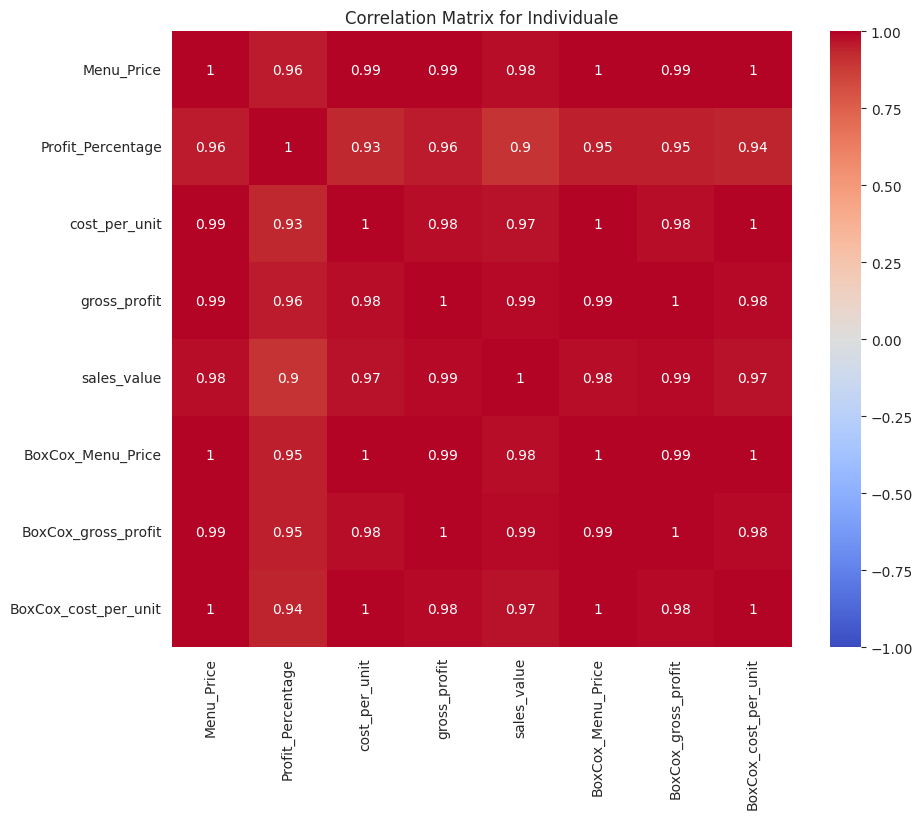

In [115]:
# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(individuale_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Individuale')
plt.show()

### Analysis of the Correlation Matrix for "Individuale"

#### Observations:

1. **High Correlation Among Features**:
    - **Menu_Price, cost_per_unit, and gross_profit**: These features exhibit very high correlation with each other (close to 1). This indicates multicollinearity among these variables.
    - **BoxCox_Transformed Features**: The transformed features (BoxCox_Menu_Price, BoxCox_gross_profit, and BoxCox_cost_per_unit) also show very high correlation with their original counterparts and among themselves.

2. **Profit_Percentage**:
    - **Correlation with Menu_Price**: There is a strong positive correlation (0.96) between Profit_Percentage and Menu_Price.
    - **Correlation with cost_per_unit**: This feature also shows high correlation with cost_per_unit (0.93) and gross_profit (0.96).

3. **BoxCox_Transformations**:
    - **BoxCox_Menu_Price**: Almost perfectly correlated with Menu_Price (1.0). This is expected as Box-Cox transformation is a monotonic transformation that doesn't change the order of data.
    - **BoxCox_gross_profit and BoxCox_cost_per_unit**: These also show very high correlation with their respective original features and among themselves.

#### Implications of Multicollinearity:
- **Redundant Information**: High correlation among features suggests that they carry redundant information. This can negatively affect the performance of regression models by increasing the variance of the coefficient estimates.
- **Model Interpretability**: High multicollinearity makes it difficult to determine the individual effect of each feature on the target variable due to overlapping information.

#### Steps to Address Multicollinearity:
1. **Feature Selection**:
    - **Remove Highly Correlated Features**: Based on the correlation matrix, you might consider removing one feature from each pair of highly correlated features to reduce redundancy. For example, if Menu_Price and BoxCox_Menu_Price are highly correlated, you might retain one and drop the other.

2. **Principal Component Analysis (PCA)**:
    - **Dimensionality Reduction**: PCA can be used to transform the features into a set of linearly uncorrelated components, thereby addressing multicollinearity.

3. **Regularization Techniques**:
    - **Ridge Regression**: This technique can help mitigate multicollinearity by adding a penalty on the size of coefficients, thus stabilizing the estimates.

#### Next Steps:
1. **Correlation Thresholding**:
    - Apply a correlation threshold (e.g., 0.95) to remove highly correlated features.
    
2. **Variance Inflation Factor (VIF)**:
    - Calculate VIF for the remaining features and remove those with VIF above a certain threshold (e.g., 10).

3. **Model Building**:
    - Build regression models using the reduced set of features and evaluate their performance.

By addressing multicollinearity, you ensure that the model is both interpretable and performs well, providing reliable predictions.

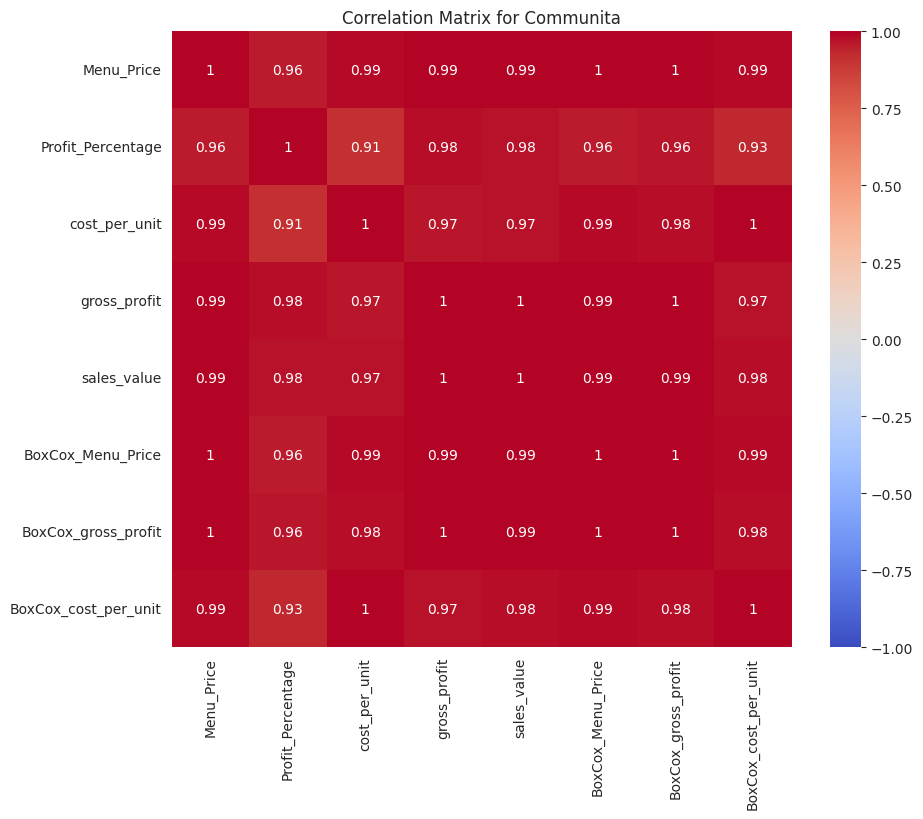

In [116]:
plt.figure(figsize=(10, 8))
sns.heatmap(communita_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Communita')
plt.show()

### Correlation Matrix Analysis for Communita

The correlation matrix for "Communita" shows the relationships between the different features after applying the Box-Cox transformation. Here's an analysis of the correlations:

#### High Correlations
1. **Menu_Price and Profit_Percentage (0.96)**:
   - A high positive correlation indicates that as the menu price increases, the profit percentage also tends to increase. This suggests that higher-priced items have higher profit margins.

2. **Menu_Price and cost_per_unit (0.99)**:
   - This near-perfect correlation suggests that the cost per unit is strongly tied to the menu price. It indicates that the menu price and the cost per unit move almost in tandem.

3. **Menu_Price and gross_profit (0.99)**:
   - A high positive correlation indicates that as the menu price increases, the gross profit also tends to increase. This is expected as higher menu prices should generally result in higher gross profits, assuming costs are managed.

4. **BoxCox_Menu_Price and other features**:
   - The transformed menu price (BoxCox_Menu_Price) maintains a near-perfect correlation with the original menu price, gross profit, and cost per unit, indicating that the transformation retains the relationships seen in the original data.

5. **gross_profit and Profit_Percentage (0.98)**:
   - This high correlation suggests that as the gross profit increases, the profit percentage also increases. This indicates that more profitable items also have higher profit margins.

6. **cost_per_unit and gross_profit (0.97)**:
   - A strong correlation between cost per unit and gross profit indicates that as the cost per unit increases, the gross profit also tends to increase. This could be due to higher cost items being priced higher and thus generating more profit.

#### Lower Correlations (Relative)
- **BoxCox_cost_per_unit and Profit_Percentage (0.93)**:
  - While still high, this is one of the lower correlations in the matrix. It suggests that there is a strong but not perfect relationship between the cost per unit and the profit percentage.

### Key Insights
1. **Highly Interrelated Features**:
   - Many features are highly interrelated, especially with Menu_Price. This indicates that changes in menu price have significant effects on other variables like gross profit, cost per unit, and profit percentage.
   
2. **Transformation Impact**:
   - The Box-Cox transformations have not drastically changed the correlations between the features. The high correlations remain, indicating that the transformation preserved the underlying relationships in the data.

3. **Potential Multicollinearity**:
   - The high correlations between many features suggest potential multicollinearity. This can affect regression models and needs to be addressed, possibly by using regularization techniques or removing some highly correlated features.

### Conclusion
The correlation matrix for "Communita" shows strong relationships between various features, particularly involving Menu_Price, gross_profit, and cost_per_unit. These insights can help in understanding how pricing strategies impact profitability and cost management for the product.

# Feature Selection

In [117]:
combined_df = pd.concat([individuale_df, communita_df])
combined_df.head()

,Product,Menu_Price,Pizza_Count,Profit_Percentage,cost_per_unit,gross_profit,sales_value,BoxCox_Menu_Price,BoxCox_gross_profit,BoxCox_cost_per_unit
1,Individuale,5.2500,6.763684,26.845586,3.840607,9.532690,35.509341,7.186613,13.799844,2.017556
2,Individuale,5.7500,6.690481,30.214454,4.012669,11.623581,38.470267,7.998698,17.431476,2.073960
3,Individuale,6.2275,6.138780,33.417930,4.146398,12.775426,38.229255,8.788955,19.492487,2.116870
4,Individuale,6.5500,5.977077,35.425975,4.229599,13.869217,39.149852,9.330455,21.486015,2.143174
5,Individuale,6.7400,5.506564,36.226450,4.298337,13.445171,37.114240,9.652312,20.709088,2.164686


In [118]:
numeric_df = combined_df.select_dtypes(include=[np.number])
numeric_df.head()

,Menu_Price,Pizza_Count,Profit_Percentage,cost_per_unit,gross_profit,sales_value,BoxCox_Menu_Price,BoxCox_gross_profit,BoxCox_cost_per_unit
1,5.2500,6.763684,26.845586,3.840607,9.532690,35.509341,7.186613,13.799844,2.017556
2,5.7500,6.690481,30.214454,4.012669,11.623581,38.470267,7.998698,17.431476,2.073960
3,6.2275,6.138780,33.417930,4.146398,12.775426,38.229255,8.788955,19.492487,2.116870
4,6.5500,5.977077,35.425975,4.229599,13.869217,39.149852,9.330455,21.486015,2.143174
5,6.7400,5.506564,36.226450,4.298337,13.445171,37.114240,9.652312,20.709088,2.164686


# Check for Multi-Collinearity with Correlation Thresholding
Method:
- Correlation Matrix Calculation: Calculates the pairwise correlation matrix of the features.
- Upper Triangle Selection: Selects the upper triangle of the correlation matrix to avoid redundancy.
- Threshold Application: Identifies features with correlation coefficients above a specified threshold (e.g., 0.95).
- Feature Removal: Removes one of the features from each pair of highly correlated features.

In [119]:
corr_matrix = numeric_df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
numeric_df

,Menu_Price,Pizza_Count,Profit_Percentage,cost_per_unit,gross_profit,sales_value,BoxCox_Menu_Price,BoxCox_gross_profit,BoxCox_cost_per_unit
1,5.2500,6.763684,26.845586,3.840607,9.532690,35.509341,7.186613,13.799844,2.017556
2,5.7500,6.690481,30.214454,4.012669,11.623581,38.470267,7.998698,17.431476,2.073960
3,6.2275,6.138780,33.417930,4.146398,12.775426,38.229255,8.788955,19.492487,2.116870
4,6.5500,5.977077,35.425975,4.229599,13.869217,39.149852,9.330455,21.486015,2.143174
5,6.7400,5.506564,36.226450,4.298337,13.445171,37.114240,9.652312,20.709088,2.164686
...,...,...,...,...,...,...,...,...,...
150,16.0000,3.164765,49.260706,8.118287,24.943770,50.636241,15.933625,103.621657,1.408857
151,16.3200,3.254308,49.061000,8.313245,26.056444,53.110300,16.251749,110.702519,1.416759
152,16.4900,3.139681,49.011439,8.408014,25.374856,51.773335,16.420747,106.345075,1.420514
153,16.5000,3.149412,48.987274,8.417100,25.456384,51.965300,16.430688,106.862977,1.420871


In [120]:
# Add the Product column back to numeric_df
numeric_df['Product'] = df['Product']

# Save the transformed dataframe
numeric_df.to_csv('./../data/transformed_price_elasticity_data.csv', index=False)